In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/gefan/Projects/scoreoperator


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ml_collections import ConfigDict
import diffrax as drx

from src.data.synthetic_shapes import Circle
from src.utils.trainer import TrainerModule
from configs.circles_eulerian import get_circles_eulerian_config as get_config
# from configs.circles_brownian import get_circles_brownian_config as get_config
from src.utils.plotting import plot_shape_with_pts, plot_trajectories
from src.utils.util import save_config

2024-04-24 17:16:57.341338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 17:16:57.341379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 17:16:57.342758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 17:16:58.413245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2024-04-24 17:16:59.671554: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


initial condition shape: (16, 2), target shape: (16, 2)


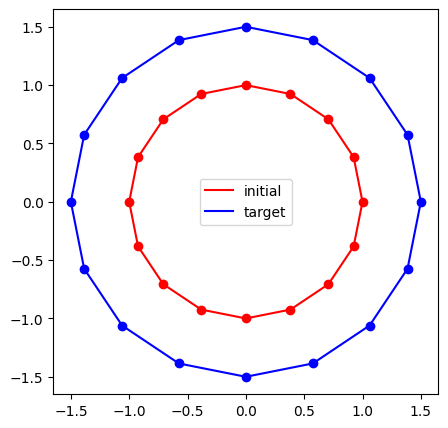

In [3]:
small_circle = Circle(r=1.0)
large_circle = Circle(r=1.5)

n_training_sample_pts = 16
small_circle_sample = small_circle.sample(n_training_sample_pts)
large_circle_sample = large_circle.sample(n_training_sample_pts)
print(f"initial condition shape: {small_circle_sample.shape}, target shape: {large_circle_sample.shape}")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = plot_shape_with_pts(ax, small_circle_sample, color='r', label='initial')
ax = plot_shape_with_pts(ax, large_circle_sample, color='b', label='target')
ax.set_aspect('equal')
ax.legend()

In [4]:
config = get_config()
config.sde.s0 = small_circle
config.sde.kappa = 0.2
config.sde.sigma = 0.1
config.training.n_pts = n_training_sample_pts
trainer = TrainerModule(
    config
)

In [5]:
xss, tss, covss, _ = next(trainer.dataloader)
print(xss.shape)

(16, 100, 32)


<Axes: xlabel='$x$', ylabel='$y$'>

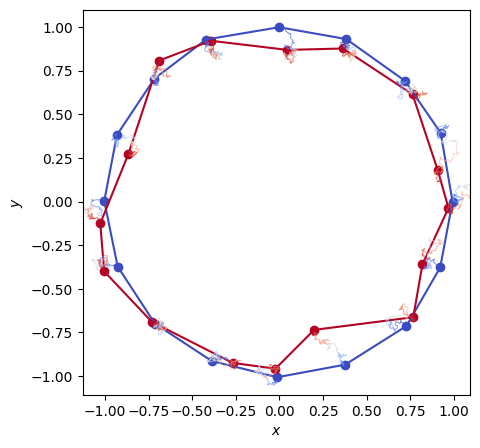

In [6]:
xs = small_circle_sample[None, :, :] + xss[0].reshape(100, n_training_sample_pts, 2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_trajectories(ax, xs, target=small_circle_sample, plot_target=False, cmap_name="coolwarm")

In [41]:
trainer.train_model(
    pretrained=True,
    load_dir="/home/gefan/Projects/scoreoperator/src/pretrained",
    prefix="circle_eulerian_16pts100"
)

Model loaded from /home/gefan/Projects/scoreoperator/src/pretrained


In [ ]:
trainer.save_model("/home/gefan/Projects/scoreoperator/src/pretrained", prefix="circle_eulerian_16pts", step=100)

In [39]:
def true_brownian_score(t, x):
    return  - x / (t+1e-6)

def est_brownian_score(t, x):
    x_ = jnp.expand_dims(x, axis=0)
    t_ = jnp.expand_dims(t, axis=0)
    score = trainer.infer_model((x_, t_))
    return score.squeeze() 

In [38]:
score_fn = lambda t, x: est_brownian_score(t, x.reshape(-1, 2)).flatten()
# score_fn = lambda t, x: true_brownian_score(t, x)

<Axes: xlabel='$x$', ylabel='$y$'>

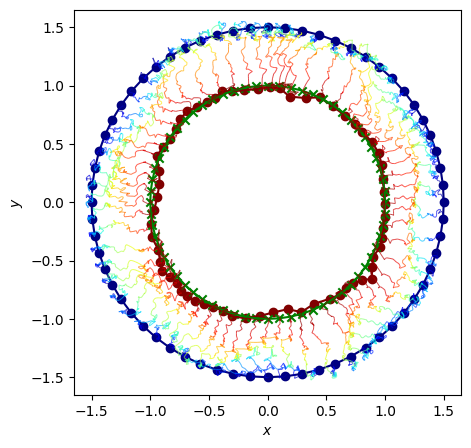

In [42]:
n_eval_sample_pts = 64
x0 = (large_circle.sample(n_eval_sample_pts) - small_circle.sample(n_eval_sample_pts)).flatten()
xs, _ = trainer.diffuser.solve_reverse_bridge_sde(rng_key=jax.random.PRNGKey(4), x0=x0, n_steps=200, score_fn=score_fn)
xs = xs.reshape(-1, n_eval_sample_pts, 2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_trajectories(ax, (xs+small_circle.sample(n_eval_sample_pts)[None, ...]), target=small_circle.sample(n_eval_sample_pts), plot_target=True, cmap_name="jet")